## Q3.9 ##

### a) ###
Consider the SVD of $X = U\Sigma V^T$, and $C$ written in terms of this SVD:

$$ 
\begin{aligned}
C &= XX^T \\
C &= (U\Sigma V^T)(U\Sigma V^T)^T \\
C &= (U\Sigma V^T)(V\Sigma^T U^T) \\
C &= U\Sigma (V^T V) \Sigma^T U^T \\
C &= U\Sigma\Sigma^T U^T \\
C &= U\tilde{\Sigma} U^T \\
\end{aligned}
$$


We can see from the above that:
- The singular values of $X$, in $\Sigma$, are the square root of the eigenvalues of $C$, in $\tilde{\Sigma}$.
- The left-singular vectors of $X$ are the eigenvectors of $C$. These vectors are both in the matrix $U$.


### b) ###
Setup code:

In [2]:
import os
import numpy as np
from numpy.linalg import norm
from scipy.io import loadmat
from scipy.linalg import svd
import plotly.offline as py
import plotly.graph_objs as go
py.offline.init_notebook_mode(connected=True)

# Load data and stack columns.
data = loadmat('yalefaces.mat')['M'].astype(np.float64)
H, W, N = data.shape
X = np.transpose(data, [1, 0, 2])
X = np.reshape(X, (H * W, -1))

# Subtract mean.
mean = np.sum(X, axis=1, keepdims=True) / N
X -= mean

# Construct C and get its eigen-pairs, 
# in decreasing order of the magnitude of the eigenvalues.
C = np.matmul(X, X.T)
U, S, V = svd(C)

In [3]:
# Plot eigenvalues.
trace = go.Scatter(
    x = np.arange(len(S)),
    y = np.log(S)
)
py.iplot([trace])

The eigenvalues are all real. This is true for any real, symmetric matrix, and $XX^T$ is real and symmetric.

### c) ###

From largest (labelled 1) to the 10th largest eigenvalue: 


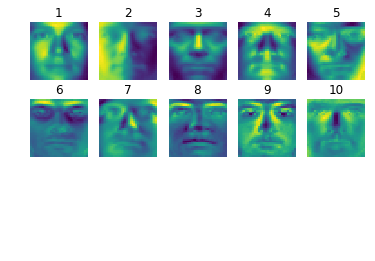

In [38]:
from matplotlib import pyplot as plt

k = 10 # The number to plot for each section.

def plot_faces(face_list, num_cols, append_str='', start_idx=1):
    num_faces = len(face_list)
    num_rows = 1 + num_faces // num_cols
    f, axarr = plt.subplots(num_rows, num_cols)
    for i in range(num_rows * num_cols):
        x = i % num_cols
        y = i // num_cols
        if i < num_faces:
            axarr[y, x].imshow(face_list[i])
            axarr[y, x].set_title(str(i + start_idx) + append_str)
        axarr[y, x].axis('off')

# Plot largest eigenfaces.
l_faces = V[:k]
l_faces = np.transpose(np.reshape(l_faces, (k, H, W)), [0, 2, 1])
print('From largest (labelled 1) to the 10th largest eigenvalue: ')
plot_faces(l_faces, 5)

From 10th smallest (labelled 1) to the smallest eigenvalue: 


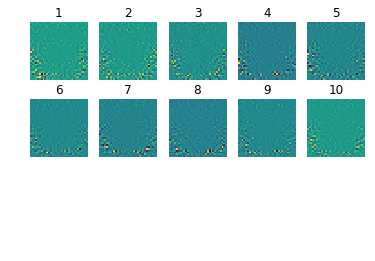

In [5]:
# Plot smallest eigenfaces (they aren't faces!).
s_faces = V[-k:]
s_faces = np.transpose(np.reshape(s_faces, (k, H, W)), [0, 2, 1])
print('From 10th smallest (labelled 1) to the smallest eigenvalue: ')
plot_faces(s_faces, 5)

The first set of eigenfaces (top 10 eigenvalue magnitudes) actually look like faces. These are supposed to capture the largest variation in the face data. The second set of eigenfaces (bottom 10 eigenvalue magnitudes) capture very little of structure in the data, and as expected, they look like noise.

### d) ###

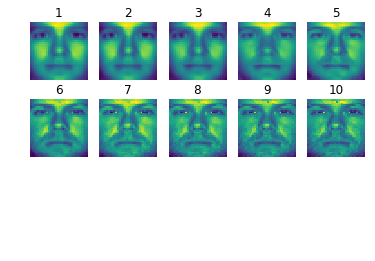

In [6]:
i_list = [1, 1076, 2043]
num_powers = 10
y_list = []

for i in i_list:
    centered_x = X[:, i-1]
    for power in range(num_powers):
        y = 0.0
        max_j = 2 ** (power + 1)
        for j in range(max_j):
            u = V[j]
            y += np.sum(u * centered_x) * u[:, None]
        y += mean
        y = np.transpose(np.reshape(y, (H, W)))
        y_list.append(y)

plot_faces(y_list[:10], 5)

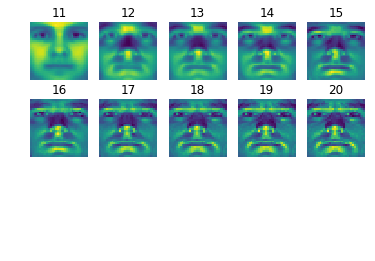

In [45]:
plot_faces(y_list[10:20], 5, start_idx=11)

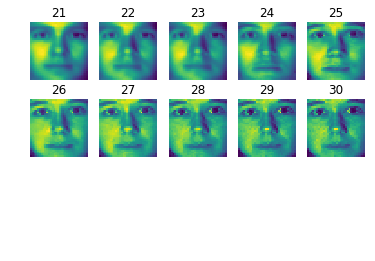

In [46]:
plot_faces(y_list[20:30], 5, start_idx=21)

### e) ###


Face images:


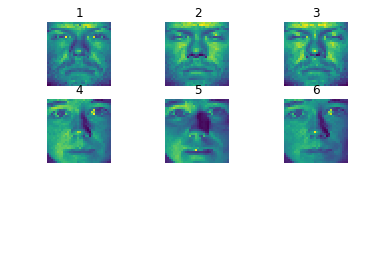

In [16]:
face_1_ids = [1, 2, 7]
face_2_ids = [2043, 2044, 2045]
face_1_list = []
face_2_list = []
num_eigenvecs = 25

def get_projections_vec(centered_x, V, num_eigenvecs):
    """
    :param centered_x: The vector of shape (n,) to project with.
    :param V: The matrix of orthonormal eigenvectors, of shape (k, n).
              k must be >= num_eigenvecs.
    :param num_eigenvecs: The number of eigenvectors to project with.
    """
    vec = []
    for i in range(num_eigenvecs):
        coeff = np.matmul(V[i].T, centered_x)
        vec.append(coeff)
    return np.array(vec)

# Compute the projection vectors for each image of the first face.
face_1_vecs = []
face_2_vecs = []
for face_id in face_1_ids:
    centered_x = X[:, face_id - 1]
    vec = get_projections_vec(centered_x, V, num_eigenvecs)
    face_1_list.append(np.reshape(centered_x, (W, H)).T)
    face_1_vecs.append(vec)

# Compute the projection vectors for each image of the second face.
for face_id in face_2_ids:
    centered_x = X[:, face_id - 1]
    vec = get_projections_vec(centered_x, V, num_eigenvecs)
    face_2_list.append(np.reshape(centered_x, (W, H)).T)
    face_2_vecs.append(vec)

print('Face images:')
plot_faces(face_1_list + face_2_list, 3)

In [37]:
def get_distance(x, y):
    return np.sqrt(np.sum((x - y) ** 2))

np.set_printoptions(suppress=True, precision=3)
all_vecs = face_1_vecs + face_2_vecs
all_idxs = face_1_ids + face_2_ids
dists = []
for i in range(len(all_vecs)):
    dists_row = []
    for j in range(len(all_vecs)):
        dist = get_distance(all_vecs[i], all_vecs[j])
        dists_row.append(np.array2string(dist, precision=1))
    dists.append(dists_row)
    
trace = go.Table(
    header=dict(values=[''] + all_idxs),
    cells=dict(values=[all_idxs] + dists))

data = [trace] 
py.iplot(data)

The intra-person images have their distances recorded in the sub-square of dimension 3x3 (The top left quarter of the full matrix for the first person, and the bottom right quarter of the full matrix for the second person). We can see that the largest of these distances is 828.4, the distance between images 2045 and 2044. The lowest distance for the inter-person images is 1082.6 between images 1 and 2043, which is larger. Therefore, these projection vectors can be used as part of a basic face recognition algorithm.

In general, we can see that the intra-person vectors for the first person have a lower pairwise distance than the vectors for the second person. This makes sense as there is more lighting change for the images of the second person; PCA is sensitive to lighting changes, as they will capture a lot of the variance in the dataset.

To build a simple face recognition scheme, we can project the "query" image onto our basis of eigenfaces (e.g up to 25 eigenfaces, as we did in our example above), and then find the nearest neighbor match within this eigenface vector space. The nearest neighbor face (whose ID we hopefully have stored already) is then the person that we are trying to identify.